In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [3]:
df.head()

movie                                               plot  \
0  "#7DaysLater" (2013)  days later interactive comedy series featuring...   
1        "#Cake" (2015)  cake hour long serial narrative comedy manhunt...   
2  "#DaddyLeaks" (????)  life four close friends late thirties change f...   
3      "#Elmira" (2014)  elmira follows story bunch strangers respond c...   
4        "#Fuga" (2016)  months apocalyptic event group survivors find ...   

                          genres  
0                     ['Comedy']  
1                     ['Comedy']  
2                     ['Comedy']  
3                     ['Comedy']  
4  ['Action', 'Drama', 'Horror']

In [4]:
genre_dict = {}
for genre_list in df['genres']:
    genre_list = genre_list[1:-1].split(', ')
    genre_list = [genre[1:-1] for genre in genre_list]
    for genre in genre_list:
        if genre not in genre_dict:
            genre_dict[genre] = 1
        else:
            genre_dict[genre] += 1

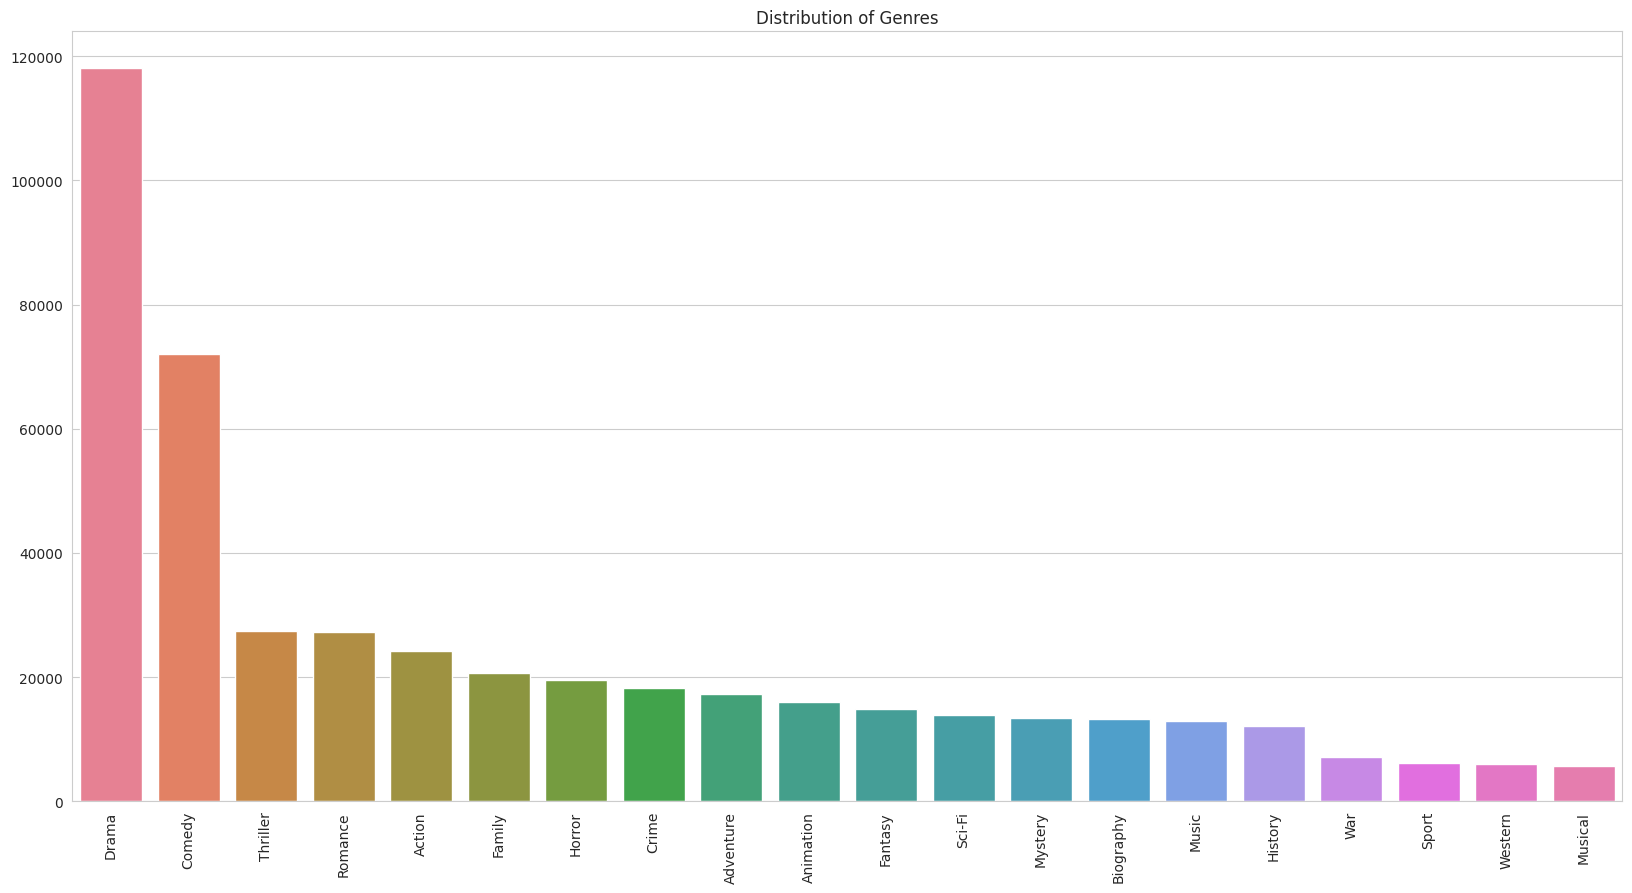

In [5]:
genre_dict

# sort the dictionary by value
genre_dict = dict(sorted(genre_dict.items(), key=lambda x: x[1], reverse=True))

# plot with seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.title('Distribution of Genres')

# color the bars
colors = sns.color_palette('pastel')[0:len(genre_dict)]
sns.barplot(x=list(genre_dict.keys()), y=list(genre_dict.values()), hue=list(genre_dict.keys()), legend=False);

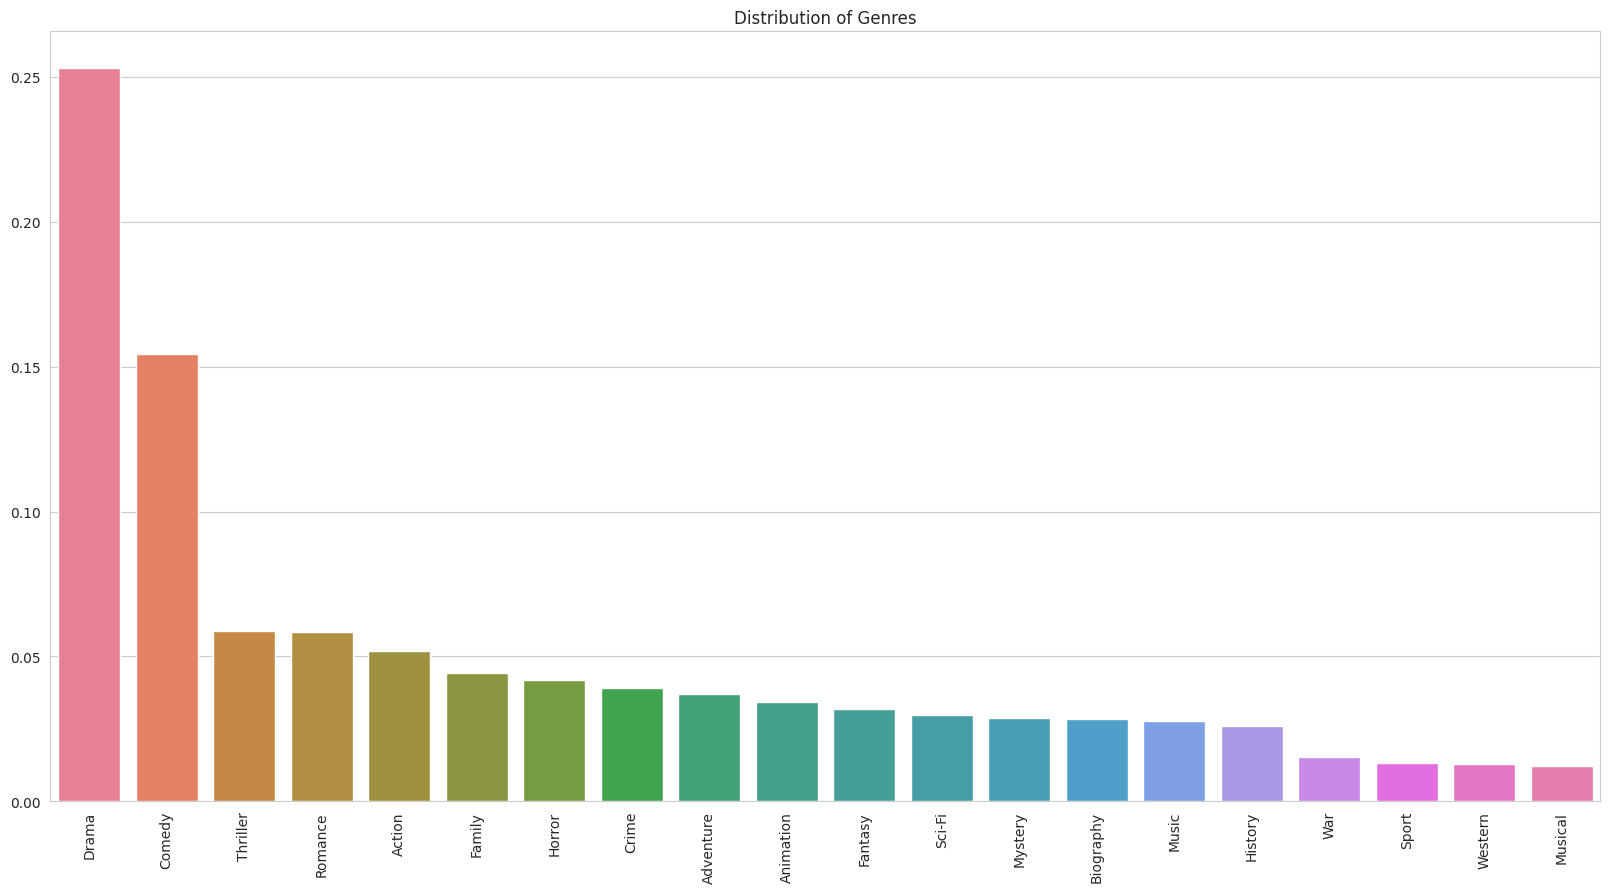

In [6]:
# show as percentage of total
total = sum(genre_dict.values())
percent_dict = {k: v / total for k, v in genre_dict.items()}

# plot with seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.title('Distribution of Genres')
sns.barplot(x=list(percent_dict.keys()), y=list(percent_dict.values()), hue=list(percent_dict.keys()), legend=False);

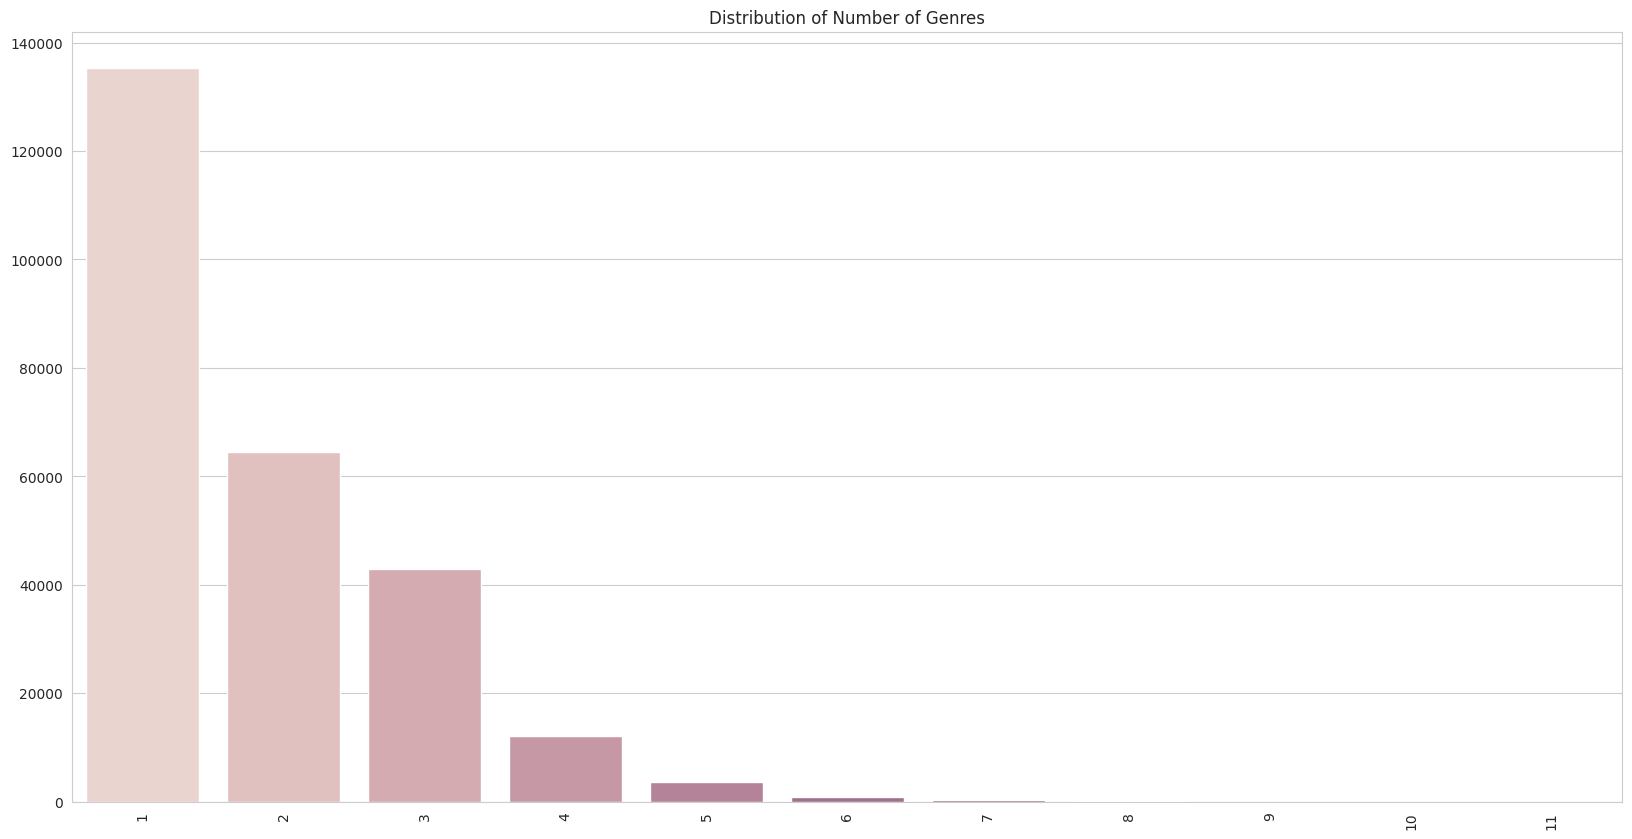

In [7]:
# plot a cdf for the number of genres
genre_count = [len(genres[1:-1].split(', ')) for genres in df['genres']]
genre_count_dict = {}

for count in genre_count:
    if count not in genre_count_dict:
        genre_count_dict[count] = 1
    else:
        genre_count_dict[count] += 1

genre_count_dict = dict(sorted(genre_count_dict.items(), key=lambda x: x[0], reverse=False))

# plot with seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.title('Distribution of Number of Genres')
sns.barplot(x=list(genre_count_dict.keys()), y=list(genre_count_dict.values()), hue=list(genre_count_dict.keys()), legend=False);

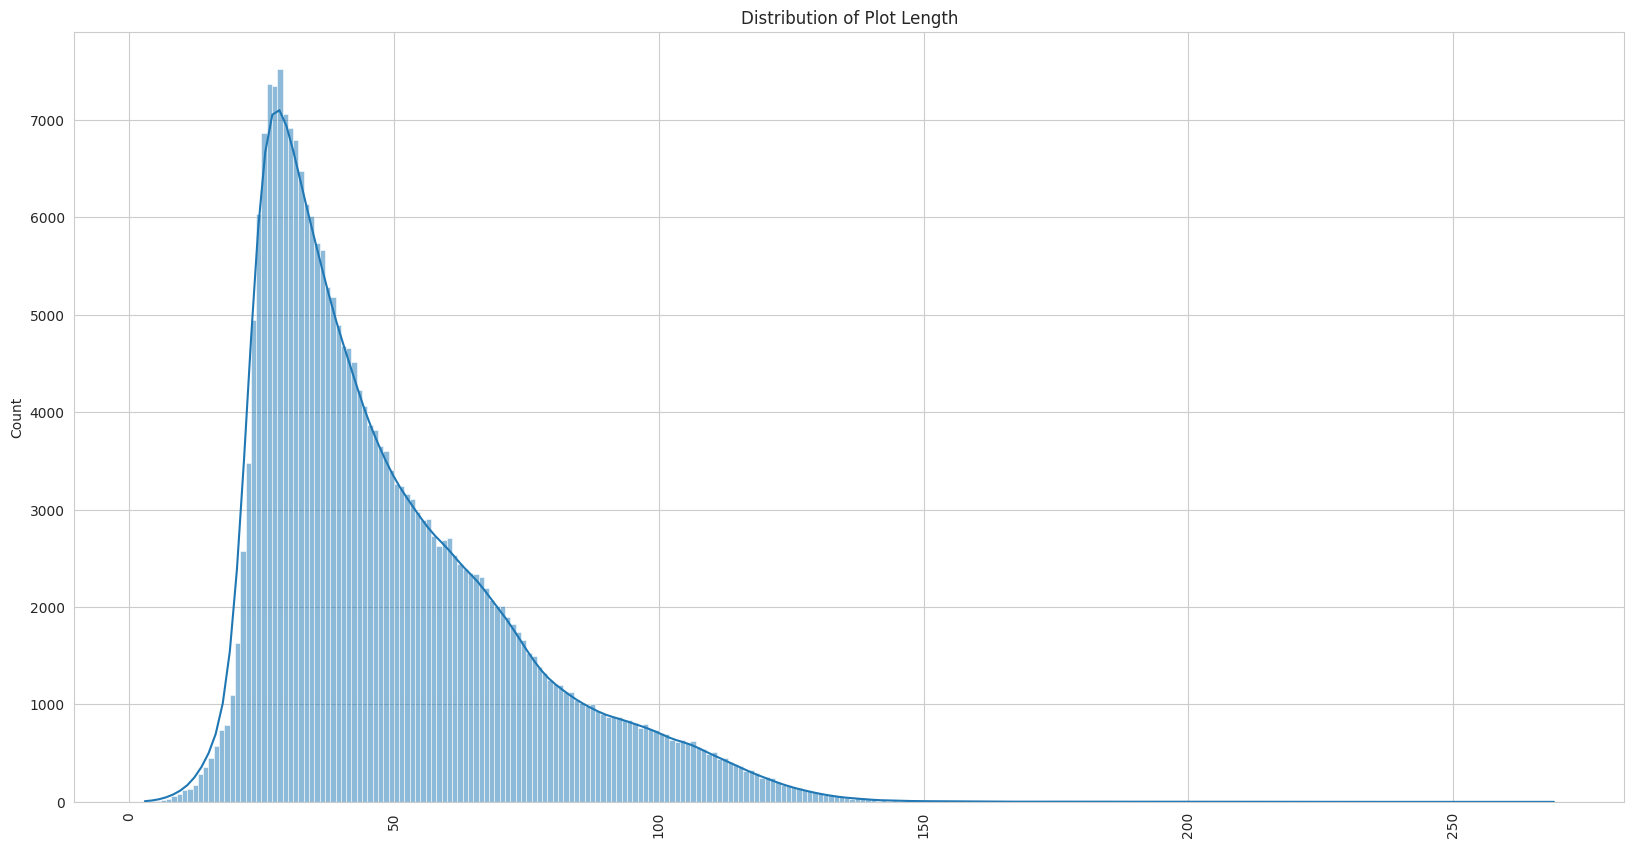

In [8]:
# make a density plot of the length of the plot
plot_length = [len(plot.split(' ')) for plot in df['plot']]
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.title('Distribution of Plot Length')
sns.histplot(plot_length, kde=True);

Number of words in whole data: 88236189


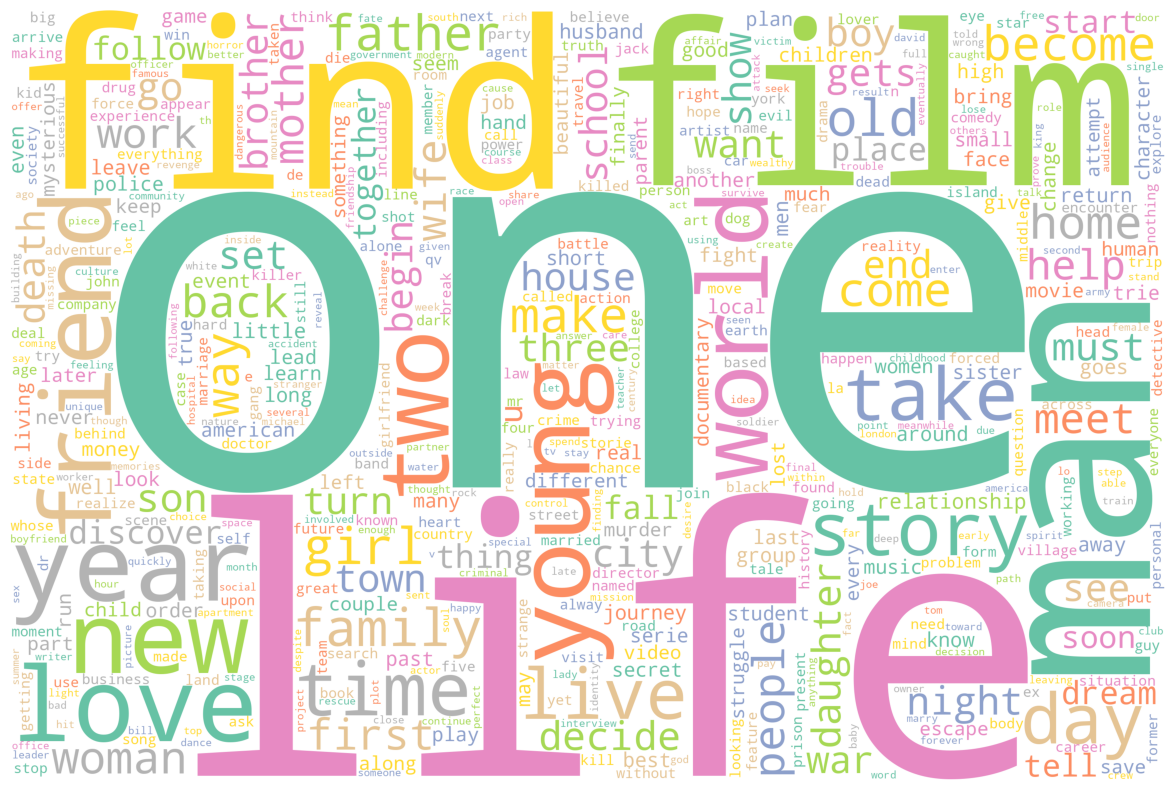

In [9]:
# create a word cloud for the plots
from wordcloud import WordCloud

text = ' '.join(df['plot'])
print('Number of words in whole data:', len(text))
wordcloud = WordCloud(width=3000, height=2000,max_words=500, random_state=1, background_color='white', colormap='Set2', collocations=False).generate(text)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
embeddings_w2v = np.load('vectorised_data/X_w2v.npy')
embeddings_tf_w2v = np.load('vectorised_data/X_tf_w2v.npy')
embeddings_doc2vec = np.load('vectorised_data/X_doc2vec.npy')

In [ ]:
output_classes = genre_dict.keys()
# colors = sns.color_palette("Spectral", as_cmap=True)
# colors = [colors(i) for i in np.linspace(0, 1, 20)]
colors = sns.color_palette('husl', len(output_classes))

def plot_embeddings(embeddings, clip=None):
    fig, ax = plt.subplots(5, 4, figsize=(20, 20))
    ax = ax.flatten()
    for i, genre in enumerate(output_classes):
        indices = df[df['genres'].str.contains(genre)]['genres'].index
        
        new_indices = []
        for j, index in enumerate(indices):
            if genre_count[index] == 1:
                new_indices.append(index)
        indices = np.array(new_indices)
        
        pca = PCA(n_components=2)
        pca_embeddings = pca.fit_transform(embeddings[indices])
        
        # sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], label=genre, ax=ax[i], s=5)
        # in above line, set different colour for each genre
        sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], ax=ax[i], s=10, color=colors[i])

        if clip:
            ax[i].set_xlim(-clip[0], clip[0])
            ax[i].set_ylim(-clip[1], clip[1])
        
        ax[i].set_title(genre)
    plt.show()

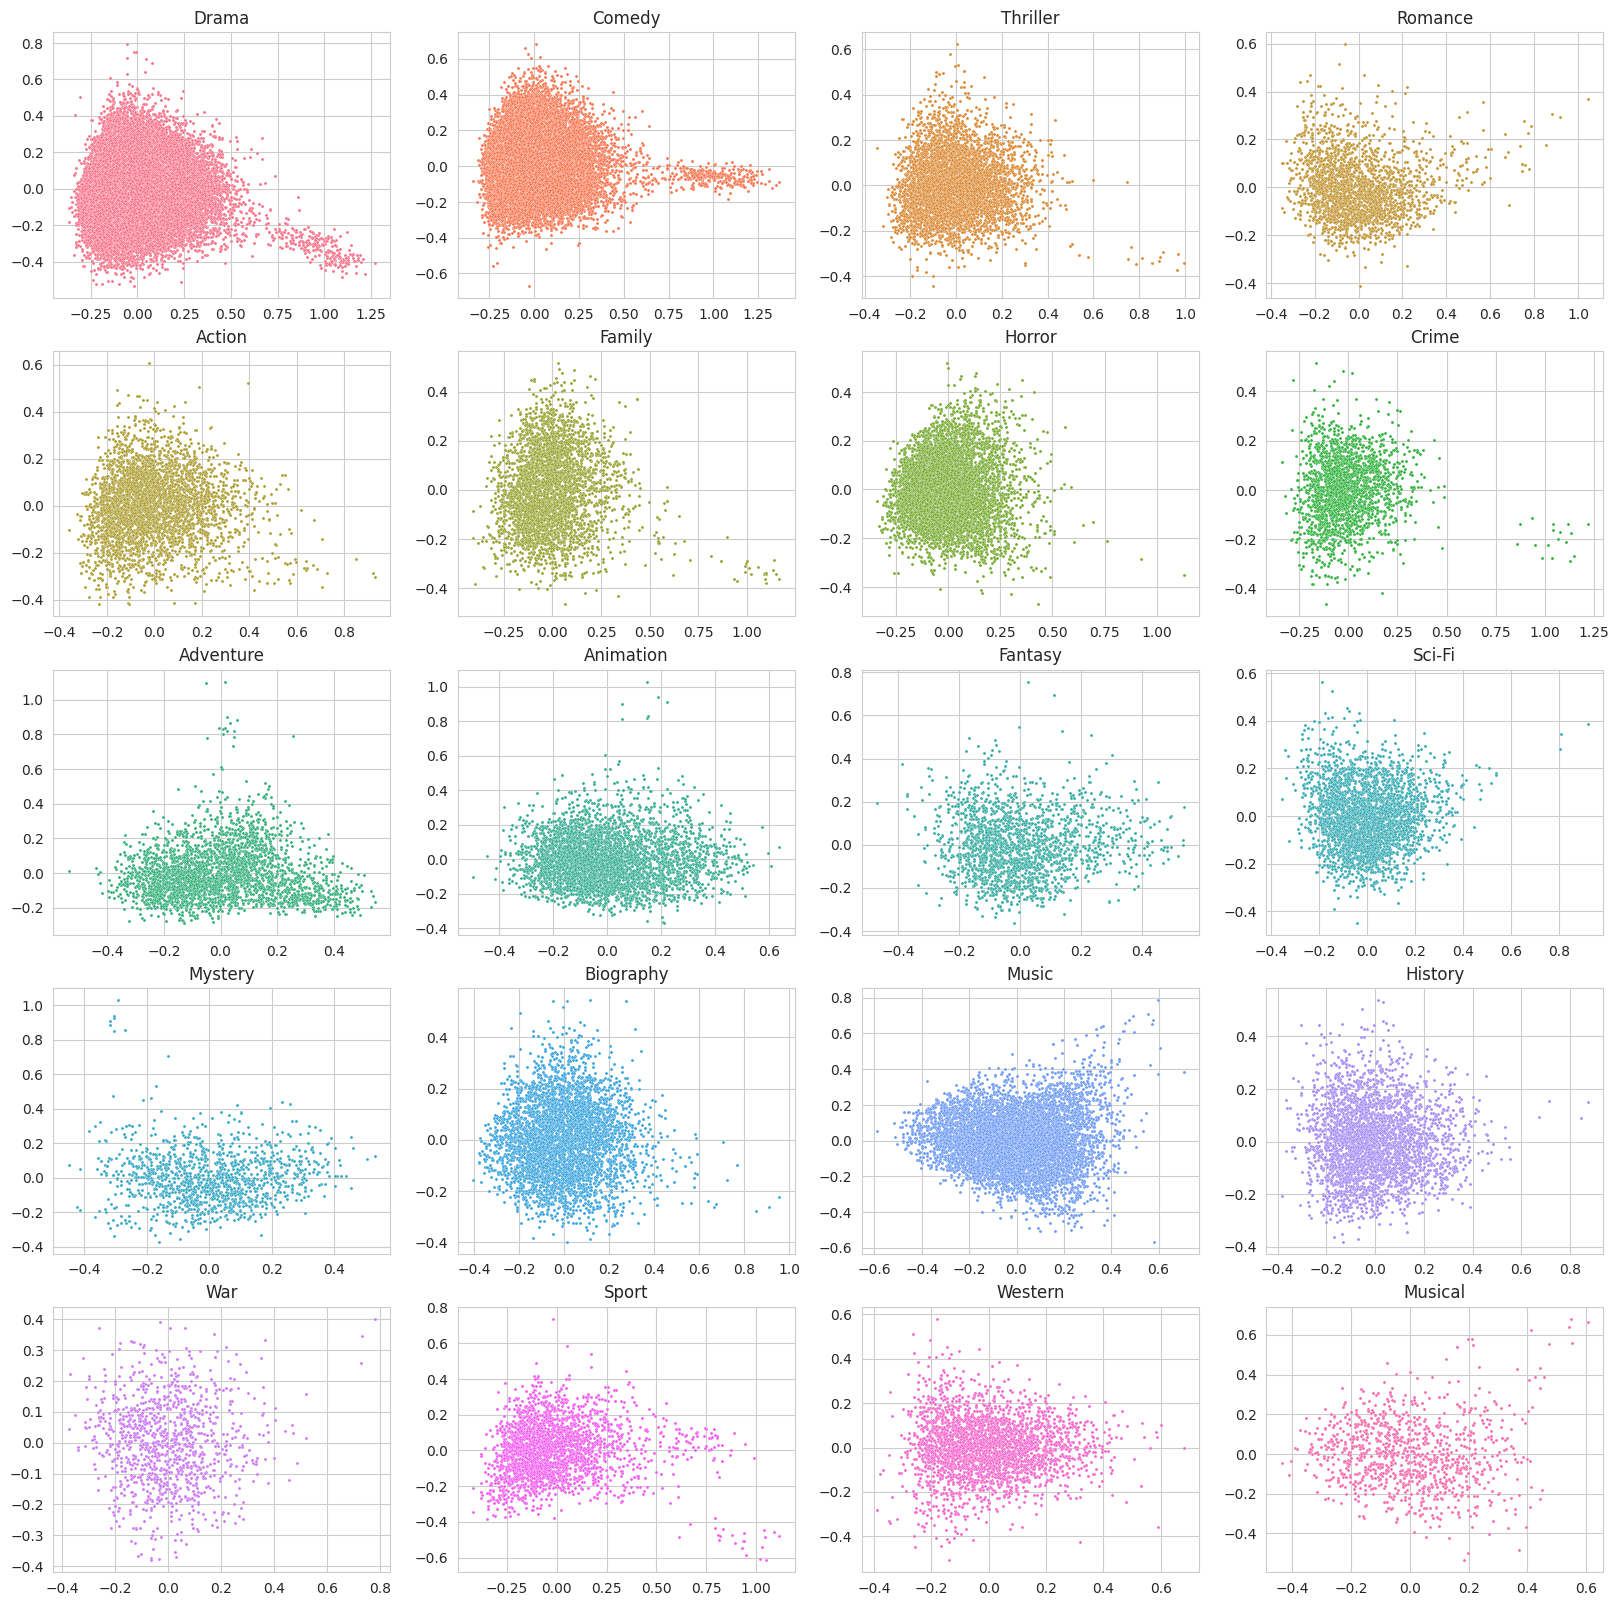

In [ ]:
plot_embeddings(embeddings_w2v)

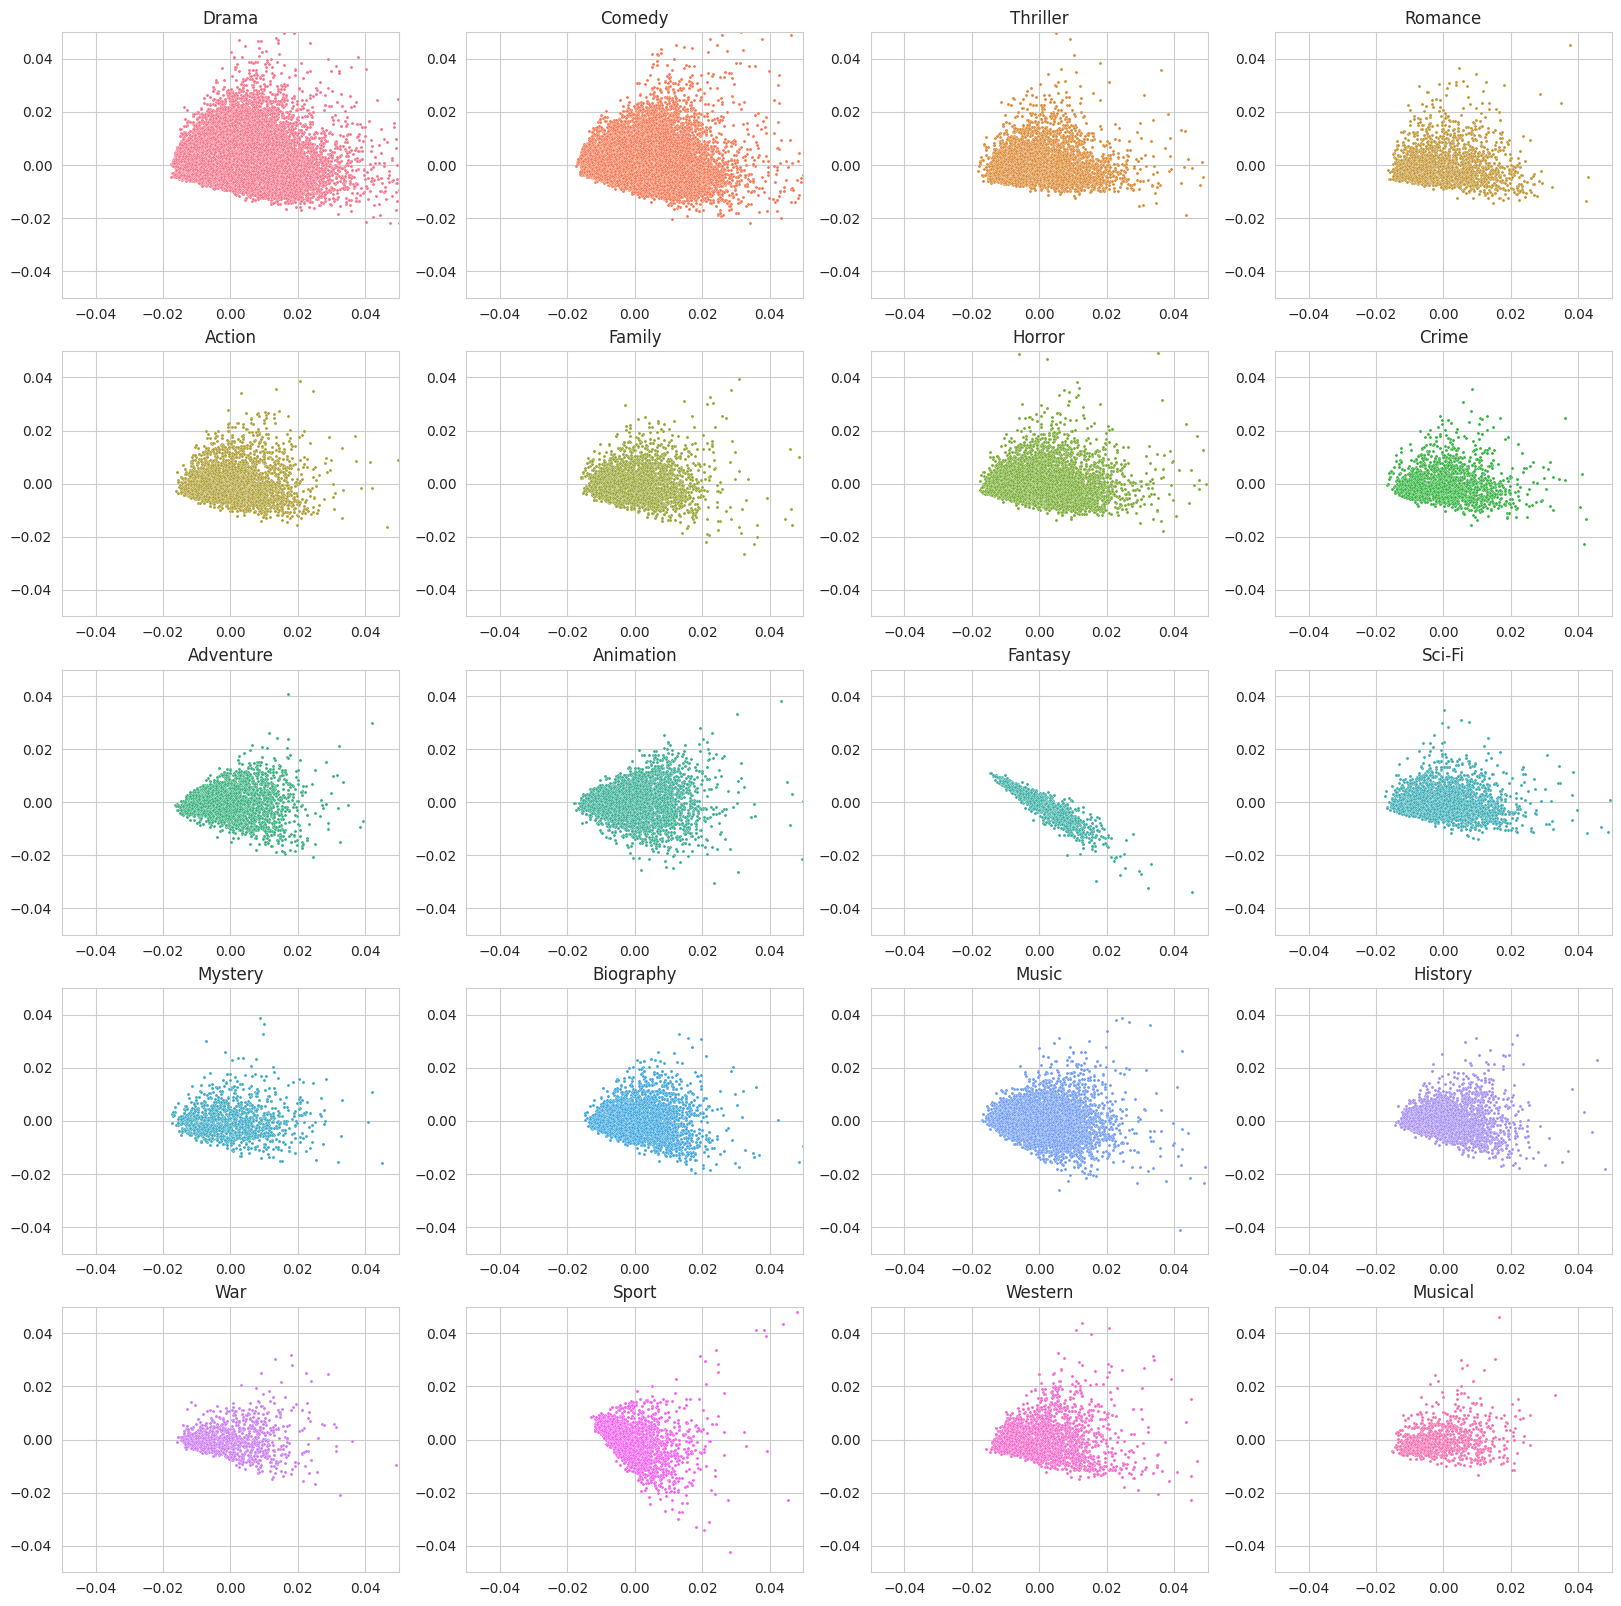

In [ ]:
plot_embeddings(embeddings_tf_w2v, clip=(0.05, 0.05))

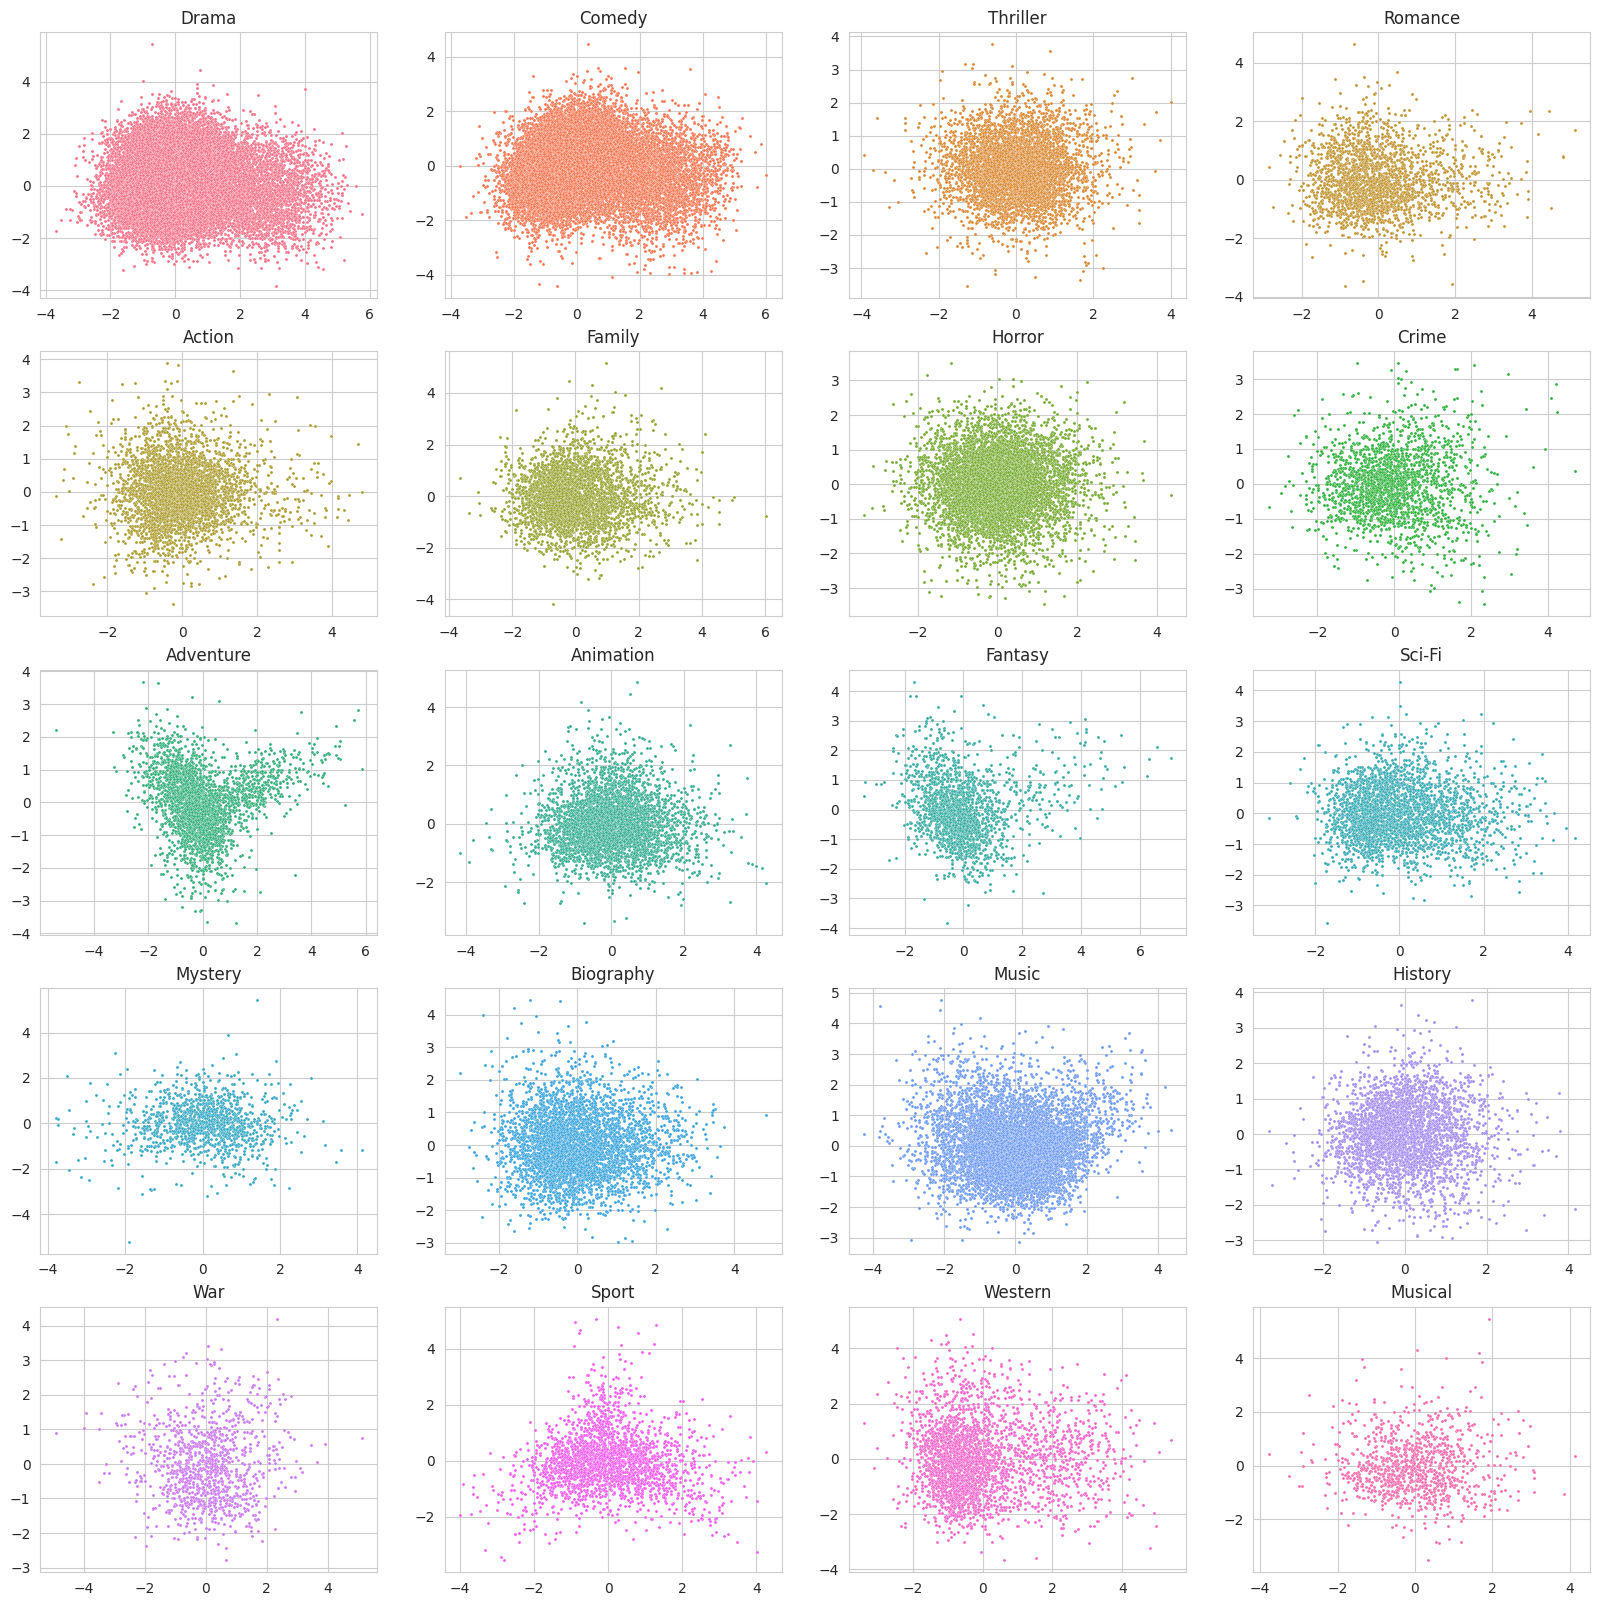

In [ ]:
plot_embeddings(embeddings_doc2vec)

In [12]:
def hit_rate(predicted, true):
    # Use element-wise logical AND to check if at least one class is predicted correctly
    correct_predictions = np.any(np.logical_and(predicted, true), axis=1)
    
    # Calculate the hit rate as the percentage of correct samples
    hit_rate = (np.sum(correct_predictions) / len(correct_predictions))
    
    return hit_rate

In [46]:
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score, classification_report

classes = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

models = ['binary_nb_tfidf', 'multi_nb_tfidf', 'xgb_w2v', 'binary_gru', 'rank_gru', 'multinomial_gru', 'transformer']
model_names = ['Binary Naive Bayes', 'Multinomial Naive Bayes', 'XGBoost', 'Binary GRU', 'Rank GRU', 'Multinomial GRU', 'Transformer']
class_report = []

paper_metrics = {
    'jaccard_score': [0.426, 0.466, 0.429, 0.465, 0.485, 0.5, 0],
    'hit_rate': [0.742, 0.829, 0.746, 0.706, 0.827, 0.805, 0],
    'f1_score': [0.52, 0.53, 0.49, 0.53, 0.56, 0.56, 0],
    'precision': [0.607, 0.507, 0.553, 0.674, 0.566, 0.610, 0],
    'recall': [0.450,0.563,0.444,0.440,0.561,0.513, 0]
}

metrics = {'jaccard_score': [], 'f1_score': [], 'precision': [], 'recall': [], 'hit_rate': []}
for model in models:
    y_pred = np.load(f'preds/{model}.npy')
    y_true = np.load(f'preds/y_test_{model}.npy')
    
    metrics['jaccard_score'].append(jaccard_score(y_true, y_pred, average='samples'))
    metrics['f1_score'].append(f1_score(y_true, y_pred, average='samples', zero_division=0))
    metrics['precision'].append(precision_score(y_true, y_pred, average='samples', zero_division=0))
    metrics['recall'].append(recall_score(y_true, y_pred, average='samples', zero_division=0))
    metrics['hit_rate'].append(hit_rate(y_true, y_pred))
    class_report.append(f1_score(y_true, y_pred, zero_division=0, average=None))

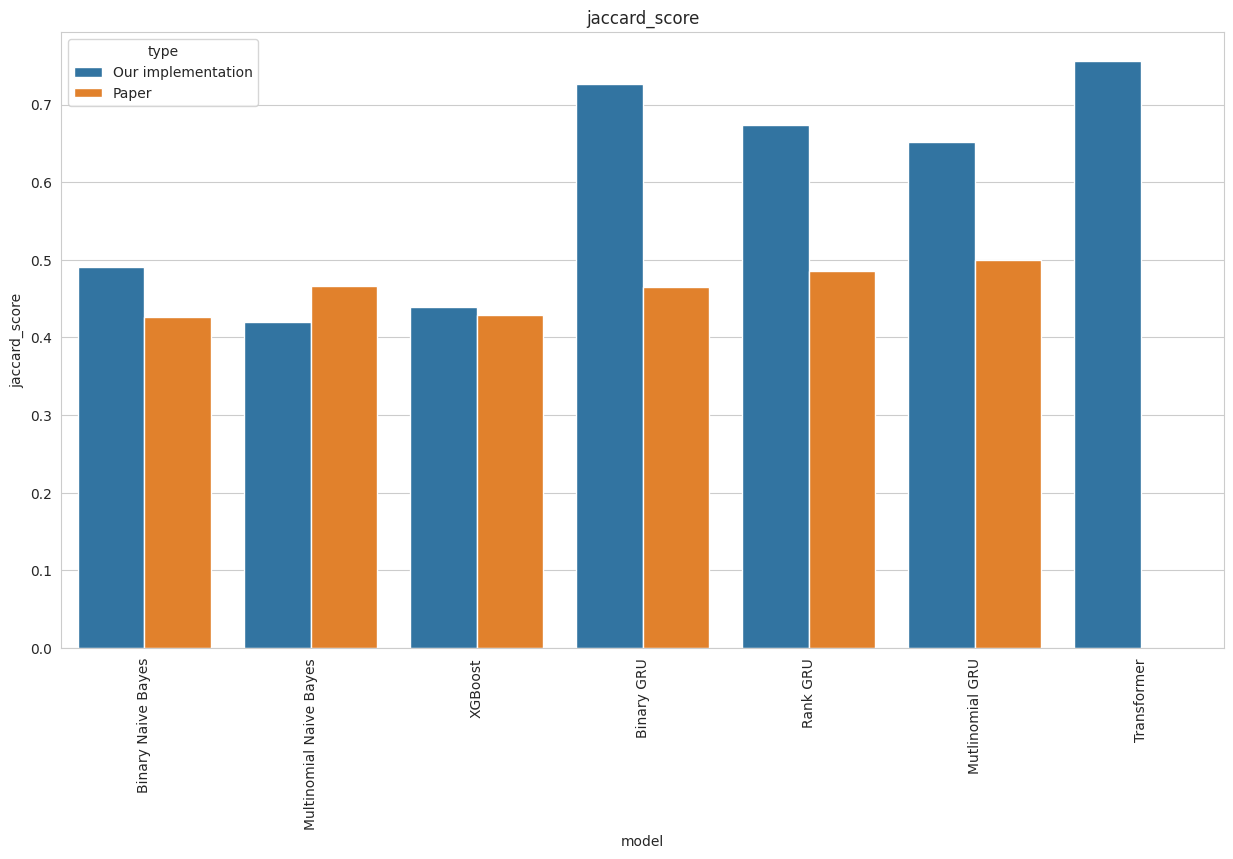

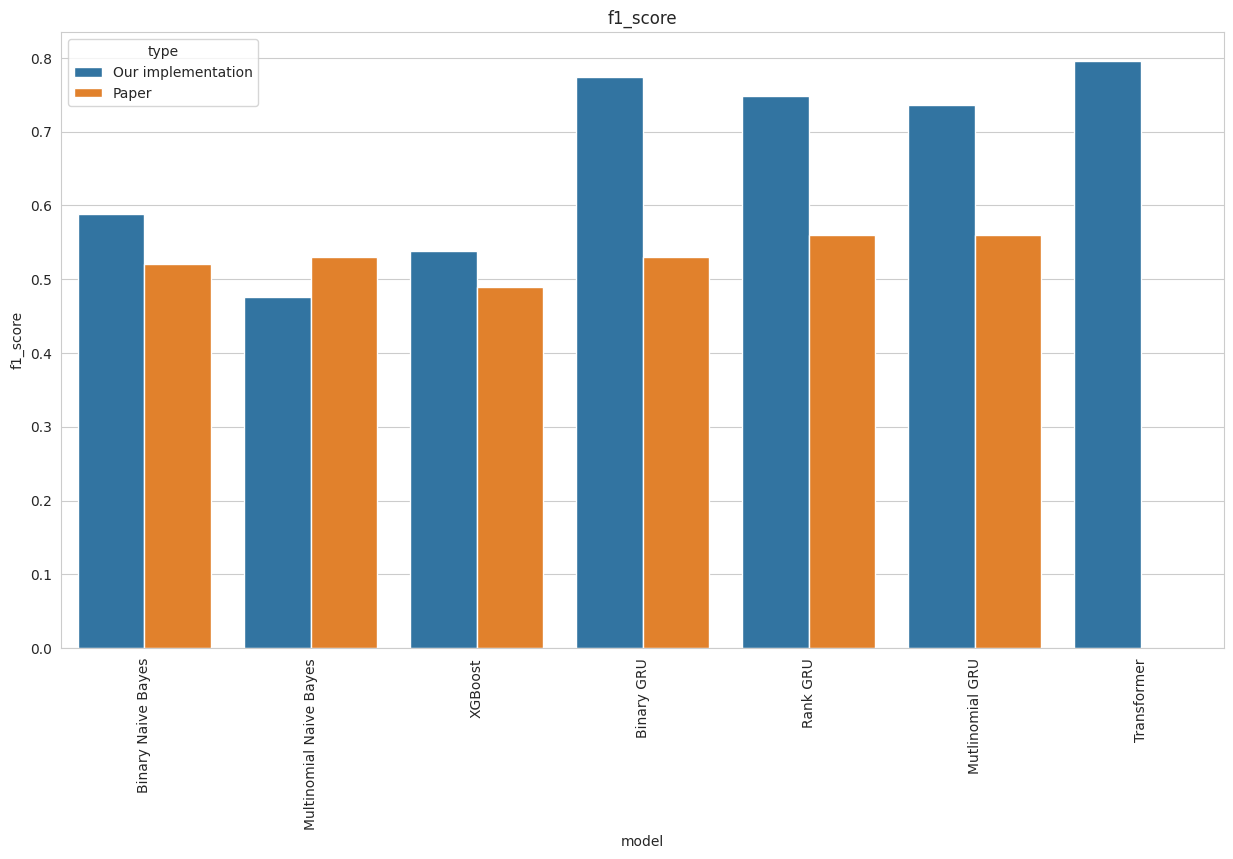

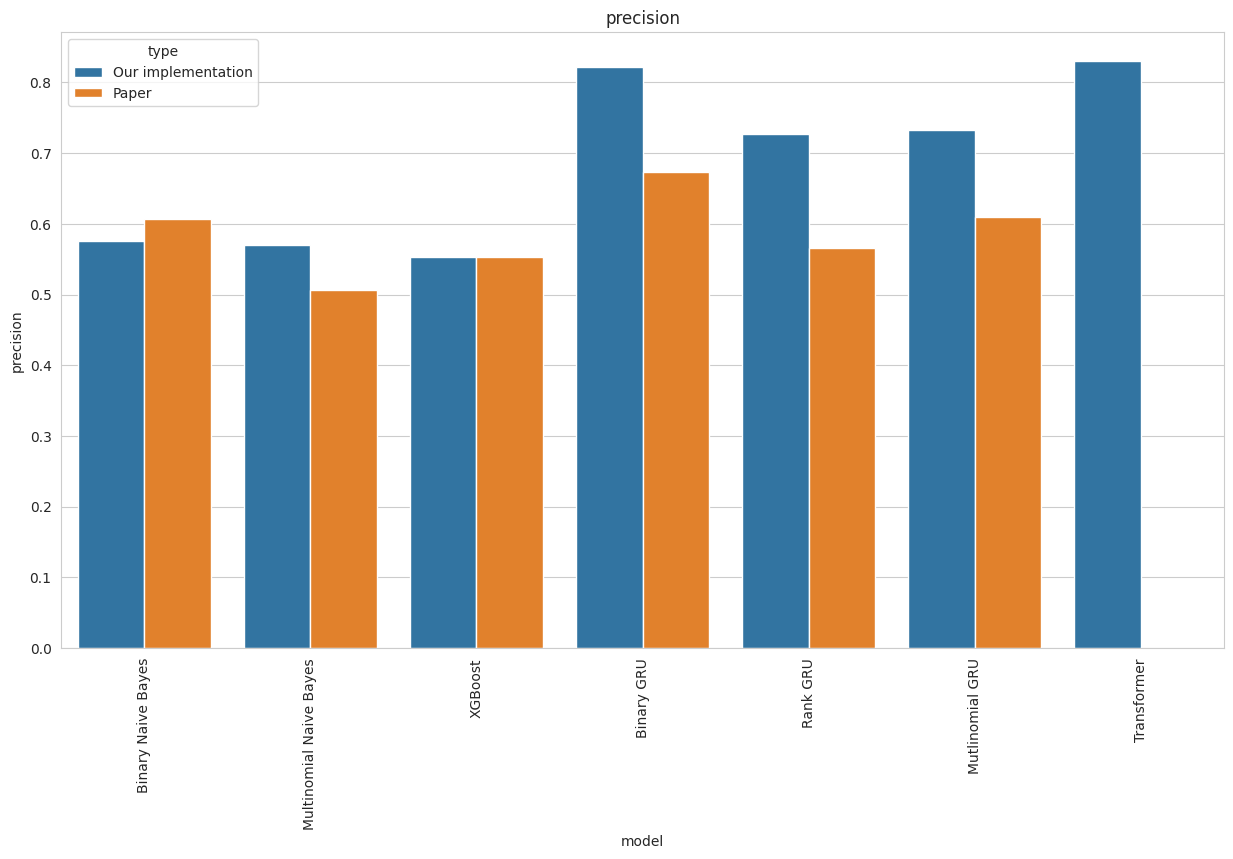

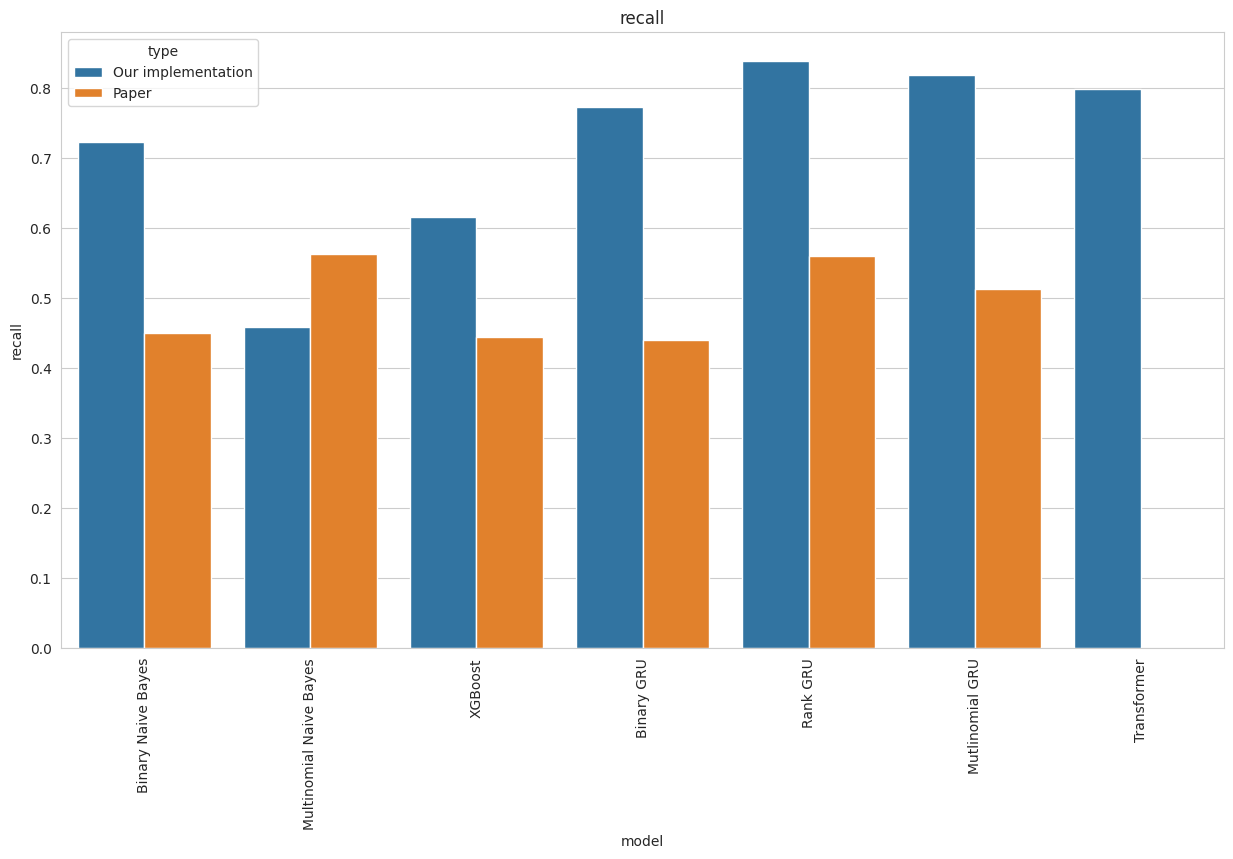

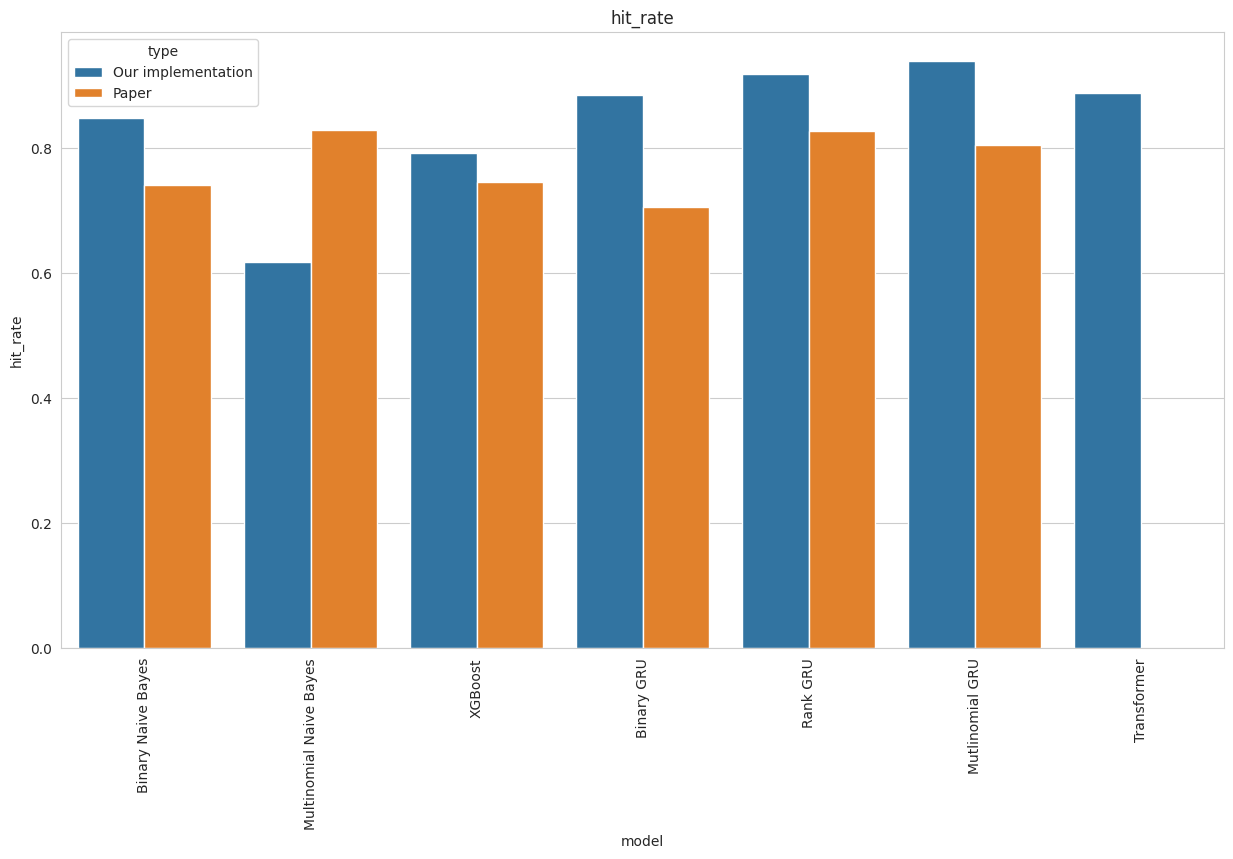

In [34]:
metrics_df = pd.DataFrame(metrics)
# add column with value Our implementation
metrics_df['model'] = model_names
metrics_df['type'] = ['Our implementation'] * len(model_names)

# concat with paper metrics
paper_metrics_df = pd.DataFrame(paper_metrics)
paper_metrics_df['model'] = model_names
paper_metrics_df['type'] = ['Paper'] * len(model_names)

metrics_df = pd.concat([metrics_df, paper_metrics_df], ignore_index=True)

sns.set_style('whitegrid')
for i, metric in enumerate(metrics):
    fig = plt.figure(figsize=(15, 8))
    sns.barplot(x='model', y=metric, hue='type', data=metrics_df)
    plt.xticks(rotation=90)
    plt.title(metric)

    plt.show()
    

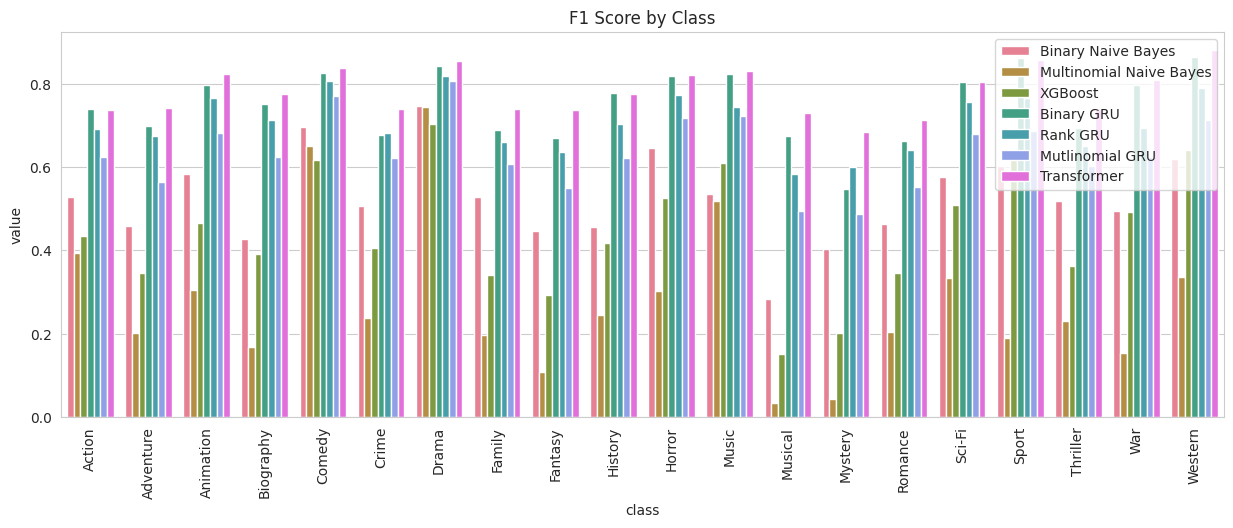

In [98]:
class_report_df = pd.DataFrame(class_report)
class_report_df['model'] = model_names
# renanme columns to class names
class_report_df.rename(columns={i: classes[i] for i in range(20)}, inplace=True)

class_report_df = class_report_df.melt(id_vars=['model'], var_name='class', value_name='value')

# plot the class report and group by class
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5))
sns.barplot(x='class', y='value', hue='model', data=class_report_df, palette='husl')
plt.xticks(rotation=90)
plt.title('F1 Score by Class')
plt.legend(loc='upper right')
plt.show()